In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### **Import Required Modules**
from architectures.py

In [194]:
import os
import pprint
import glob
import json
from tqdm import tqdm
# import cv2
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# from architectures import (
#     FilenameDataset,
#     get_incidents_model,
#     update_incidents_model_with_checkpoint,
#     update_incidents_model_to_eval_mode,
#     get_predictions_from_model
# )
# from parser import get_parser, get_postprocessed_args

#### `Code snippets from architectures.py`

In [195]:
# Imports from the architectures.py file

# import torch Already imported top!
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from torch.nn import functional as F
import torch.optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from skimage import io

import numpy as np
import os

from PIL import Image


**Class: `FilenameDataset`**

In [196]:
                                            # ! Dummy code

class FilenameDataset(data.Dataset):
    """
    Data loader for filenames and their corresponding labels.
    """

    def __init__(self, image_filenames, targets):
        """
        Args:
            image_filenames (list): List of image filenames
            targets (list): List of integers that correspond to target class indices
        """
        assert (len(image_filenames) == len(targets))
        self.image_filenames = image_filenames
        print("image filenames are: ", self.image_filenames)
        print("Targets are: ", self.image_filenames)
        self.targets = targets

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the target class index
        """
        image_filename = self.image_filenames[index]
        # if not os.path.isfile(image_filename):
        #     os.system("ln -s {} {}".format(image_filename.replace("/data/vision/torralba/humanitarian/datasets/images_raw/",
        #                                                           "/data/vision/torralba/humanitarian/dimitris/getGoogleImages2/finalImages/"), image_filename))
        if not os.path.isfile(image_filename):
            raise ValueError("{} is not a file".format(image_filename))
        
        try:
            with open(image_filename, 'rb') as f:
                image = Image.open(f).convert('RGB')
                image = inference_loader(image)
        except:
            print(image_filename)
            image = Image.new('RGB', (300, 300), 'white')
            image = inference_loader(image)
        return image, self.targets[index]

    def __len__(self):
        return len(self.image_filenames)


REVIEW: I have to replace this args with a hardcoded object!

In [197]:
def get_incident_layer(activation="sigmoid", fc_dim=1024, num_incidents=43):
    if activation == "softmax":
        return nn.Linear(fc_dim, num_incidents + 1)
    elif activation == "sigmoid":
        return nn.Linear(fc_dim, num_incidents)

In [198]:
def get_place_layer(activation="sigmoid", fc_dim=1024, num_places=49):
    if activation == "softmax":
        return nn.Linear(fc_dim, num_places + 1)
    elif activation == "sigmoid":
        return nn.Linear(fc_dim, num_places)

In [199]:
# NOTE: Can simple replace args with arch(the model architecture!)



# This is the actual file that we require.. But much simplified!
# ! I suppose we require pretrained with places, since it uses the model with the pretrained weights. 

def get_trunk_model(arch="resnet50", pretrained_with_places=True):
    if pretrained_with_places:
        print("loading places weights for pretraining")
        # Declare the model here
        model = models.__dict__[arch](num_classes=365)

        # dir_path = os.path.dirname(os.path.realpath(__file__))
        
        # Get the current working directory
        dir_path = os.getcwd()
        print("Current Directory:", dir_path)


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # ! Args has an arch property
        if arch == "resnet18":
            model_file = os.path.join(
                dir_path, "pretrained_weights/resnet18_places365.pth.tar"
            )

            checkpoint = torch.load(model_file, map_location=device)
            
            state_dict = {
                str.replace(k, 'module.', ''): v for k,
                    v in checkpoint['state_dict'].items()
                }
            
            # Load the model
            model.load_state_dict(state_dict)
            
            model.fc = nn.Linear(512, 1024)
            model = nn.Sequential(model, nn.ReLU())
        
        elif arch == "resnet50":
            model_file = os.path.join(
                dir_path, "pretrained_weights/resnet50_places365.pth.tar"
            )

            checkpoint = torch.load(model_file, map_location=device)
            
            state_dict = {
                str.replace(k, 'module.', ''): v for k,
                    v in checkpoint['state_dict'].items()
                }
            model.load_state_dict(state_dict)
            
            model.fc = nn.Linear(2048, 1024)
            model = nn.Sequential(model, nn.ReLU())
        return model
    
    else:
        # Need to avoid this else statement
        print("loading imagenet weights for pretraining")
        # Otherwise load with imagenet weights
        if arch == "resnet18":
            model = models.resnet18(pretrained=True)
            model.fc = nn.Linear(512, 1024)
            model = nn.Sequential(model, nn.ReLU())
        
        elif arch == "resnet50":
            model = models.resnet50(pretrained=True)
            model.fc = nn.Linear(2048, 1024)
            model = nn.Sequential(model, nn.ReLU())
        return model

In [200]:
"""
Args:
    num_gpus
"""

def get_incidents_model():
    """
    Returns [trunk_model, incident_layer, place_layer]
    """
    # the shared feature trunk model
    trunk_model = get_trunk_model()
    # the incident model
    incident_layer = get_incident_layer()
    # the place model
    place_layer = get_place_layer()

    # print("Let's use", num_gpus, "GPUs!")


    trunk_model = torch.nn.DataParallel(
        # trunk_model, device_ids=range(args.num_gpus)
        trunk_model
    )
    
    incident_layer = torch.nn.DataParallel(
        # incident_layer, device_ids=range(args.num_gpus)
        incident_layer
    )
    
    place_layer = torch.nn.DataParallel(
        place_layer
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trunk_model.to(device)
    incident_layer.to(device)
    place_layer.to(device)
    return [trunk_model, incident_layer, place_layer]

In [201]:
"""
    args:
        mode
        checkpoint_path
        trunk_resume
        config
        mode
        checkpoint_path
        start_epoch
"""

def update_incidents_model_with_checkpoint(incidents_model, mode="",config="config/eccv_final_model", checkpoint_path="pretrained_weights/"):

    """
    Update incidents model with checkpoints (in args.checkpoint_path)
    """

    trunk_model, incident_layer, place_layer = incidents_model

    # TODO: optionally resume from a checkpoint
    # TODO: bring in the original pretrained weights maybe?
    # TODO: remove the args.trunk_resume, etc.
    # TODO: remove path prefix

    config_name = os.path.basename(config)
    print(config_name)

    best_str = "_best" if mode == "test" else ""

    trunk_resume = os.path.join(
        checkpoint_path, "eccv_final_model_trunk{}.pth.tar".format(best_str))
    place_resume = os.path.join(
        checkpoint_path, "eccv_final_model_place{}.pth.tar".format(best_str))
    incident_resume = os.path.join(
        checkpoint_path, "eccv_final_model_incident{}.pth.tar".format(best_str))

    # trunk_resume = "/data/vision/torralba/scratch/ethanweber/DamageAssessment/external/IncidentsDataset/pretrained_weights/eccv_final_model_trunk.pth.tar"
    # place_resume = "/data/vision/torralba/scratch/ethanweber/DamageAssessment/external/IncidentsDataset/pretrained_weights/eccv_final_model_place.pth.tar"
    # incident_resume = "/data/vision/torralba/scratch/ethanweber/DamageAssessment/external/IncidentsDataset/pretrained_weights/eccv_final_model_incident.pth.tar"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for (path, net) in [(trunk_resume, trunk_model), (place_resume, place_layer), (incident_resume, incident_layer)]:
        if os.path.isfile(path):
            checkpoint = torch.load(path, map_location=device)
            start_epoch = checkpoint['epoch']
            net.load_state_dict(checkpoint['state_dict'])
            print("Loaded checkpoint '{}' (epoch {}).".format(
                path, checkpoint['epoch']))
        else:
            print("No checkpoint found at '{}'.".format(path))



In [202]:

def update_incidents_model_to_eval_mode(incidents_model):
    print("Switching to eval mode.")
    for m in incidents_model:
        # switch to evaluation mode
        m.eval()



In [203]:

"""
Args:
    activation
"""

def get_predictions_from_model(
    incidents_model,
    batch_input,
    image_paths,
    index_to_incident_mapping,
    index_to_place_mapping,
    inference_dict,
    topk=1,
    activation="softmax",
):
    """
    Input:
    {
        "image_paths" = [list of image paths],
    }
    Returns {
        "incidents": [], # list of topk elements
        "places": [] # list of topk elements
    }
    """
    print("Trying to load the model!")

    trunk_model, incident_layer, place_layer = incidents_model

    # loaded the model
    print("Loaded the model!!")

    # compute output with models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    input = batch_input.to(device)
    output = trunk_model(input)
    incident_output = incident_layer(output)
    place_output = place_layer(output)

    if activation == "softmax":
        incident_output = F.softmax(incident_output, dim=1)
        place_output = F.softmax(place_output, dim=1)
    elif activation == "sigmoid":
        m = nn.Sigmoid()
        incident_output = m(incident_output)
        place_output = m(place_output)

    incident_probs, incident_idx = incident_output.sort(1, True)
    place_probs, place_idx = place_output.sort(1, True)

    temp_inference_dict = {}

    # batch_input[0] is the batch dimension (the # in the batch)
    for batch_idx in range(len(batch_input.numpy())):
        incidents = []
        for idx in incident_idx[batch_idx].cpu().numpy()[:topk]:
            if idx < len(index_to_incident_mapping):
                incidents.append(
                    index_to_incident_mapping[idx]
                )
            else:
                incidents.append("no incident")

        places = []
        for idx in place_idx[batch_idx].cpu().numpy()[:topk]:
            if idx < len(index_to_place_mapping):
                places.append(
                    index_to_place_mapping[idx]
                )
            else:
                places.append("no place")

        output = {
            "incidents": incidents,
            "places": places,
            "incident_probs": incident_probs[batch_idx].cpu().detach().numpy()[:topk],
            "place_probs": place_probs[batch_idx].cpu().detach().numpy()[:topk]
        }
        image_path = image_paths[batch_idx]
        temp_inference_dict[image_path] = output

    # TODO: maybe return the output here
    if inference_dict is not None:
        inference_dict.update(temp_inference_dict)
    return temp_inference_dict



In [204]:

def get_predictions_from_model_all(args, incidents_model, batch_input, image_paths, index_to_incident_mapping,
                                   index_to_place_mapping, inference_dict, softmax=True):
    """
    Input:
    {
        "image_paths" = [list of image paths],
    }
    Returns {
        "incidents": [], # list of topk elements
        "places": [] # list of topk elements
    }
    """
    trunk_model, incident_layer, place_layer = incidents_model

    # compute output with models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input = batch_input.to(device)
    output = trunk_model(input)
    incident_output = incident_layer(output)
    place_output = place_layer(output)

    if softmax:
        incident_output = F.softmax(incident_output, dim=1)
        place_output = F.softmax(place_output, dim=1)
    else:
        m = nn.Sigmoid()
        incident_output = m(incident_output)
        place_output = m(place_output)

    incident_probs, incident_idx = incident_output.sort(1, True)
    place_probs, place_idx = place_output.sort(1, True)

    # batch_input[0] is the batch dimension (the # in the batch)
    for batch_idx in range(len(batch_input.numpy())):
        incidents = []
        for idx in incident_idx[batch_idx].cpu().numpy():
            if idx < len(index_to_incident_mapping):
                incidents.append(
                    index_to_incident_mapping[idx]
                )
            else:
                incidents.append("no incident")

        places = []
        for idx in place_idx[batch_idx].cpu().numpy():
            if idx < len(index_to_place_mapping):
                places.append(
                    index_to_place_mapping[idx]
                )
            else:
                places.append("no place")

        output = {
            "incidents": incidents,
            "places": places,
            "incident_probs": incident_probs[batch_idx].cpu().detach().numpy(),
            "place_probs": place_probs[batch_idx].cpu().detach().numpy()
        }
        image_path = image_paths[batch_idx]
        inference_dict[image_path] = output

    # TODO: maybe return the output here
    return None



In [205]:

def get_features_from_model(incidents_model, batch_input, image_paths, inference_dict):
    """
    Input:
    {
        "image_paths" = [list of image paths],
    }
    Returns trunk_model output.
    """
    trunk_model, incident_layer, place_layer = incidents_model

    # compute output with models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input = batch_input.to(device)
    output = trunk_model(input)

    # batch_input[0] is the batch dimension (the # in the batch)
    for batch_idx in range(len(batch_input.numpy())):
        out = output[batch_idx].cpu().detach().numpy()
        # print("here")
        # print(out)
        # print(out.shape)
        # print(type(out))
        image_path = image_paths[batch_idx]
        inference_dict[image_path] = out

    # TODO: maybe return the output here
    return None


## **`Run Model script beneath here`**

In [206]:
# data
image_filenames = sorted(
    glob.glob("test_images/*")
)

print(image_filenames)


['test_images\\earthquake.jpg', 'test_images\\fire.jpg', 'test_images\\flood.jpg', 'test_images\\ship.jpg']


In [207]:
import cv2

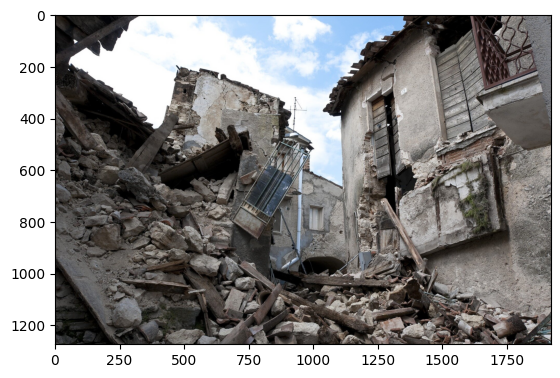

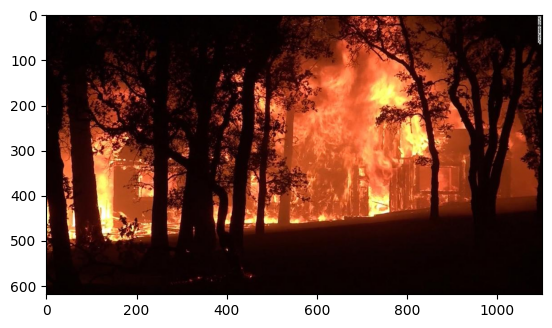

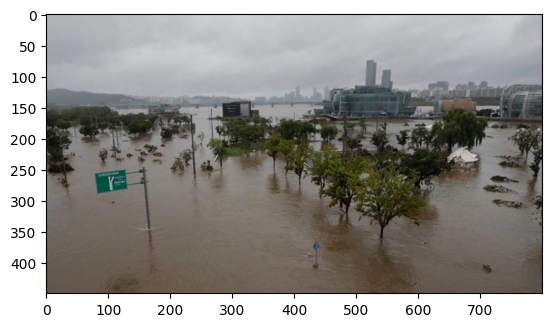

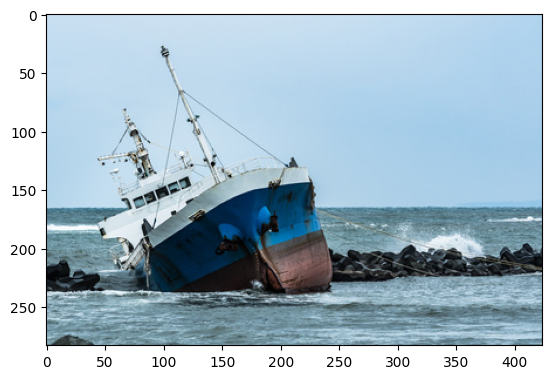

In [208]:
for image_filename in image_filenames:
    img = cv2.imread(image_filename)[:, :, ::-1].copy()
    plt.imshow(img)
    plt.show()


### `Load the model`

In [209]:
# Load model from checkpoint.
# parser = get_parser()
# args = parser.parse_args(
#     args="--config={} --checkpoint_path={} --mode=test --num_gpus=0".format(CONFIG_FILENAME, CHECKPOINT_PATH_FOLDER))
# args = get_postprocessed_args(args)

# print(args)

incidents_model = get_incidents_model() # Get the model with pretrained weights
update_incidents_model_with_checkpoint(incidents_model)
update_incidents_model_to_eval_mode(incidents_model) # Set the model mode to evaluation


loading places weights for pretraining
Current Directory: d:\Qasim\Coding\Python\BenificiaryVerificaion
eccv_final_model
Loaded checkpoint 'pretrained_weights/eccv_final_model_trunk.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/eccv_final_model_place.pth.tar' (epoch 15).
Loaded checkpoint 'pretrained_weights/eccv_final_model_incident.pth.tar' (epoch 15).
Switching to eval mode.


In [210]:
from utils import get_index_to_incident_mapping, get_index_to_place_mapping


In [211]:
                                            # ! Dummy Code! 

# Set up the data loader for quickly loading images to run inference with.
print("num images: {}".format(len(image_filenames)))
targets = [image_filenames[i] for i in range(len(image_filenames))]
dataset = FilenameDataset(image_filenames, targets)

print(image_filenames)
print(targets)

print(dataset)

loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1
)


num images: 4
image filenames are:  ['test_images\\earthquake.jpg', 'test_images\\fire.jpg', 'test_images\\flood.jpg', 'test_images\\ship.jpg']
Targets are:  ['test_images\\earthquake.jpg', 'test_images\\fire.jpg', 'test_images\\flood.jpg', 'test_images\\ship.jpg']
['test_images\\earthquake.jpg', 'test_images\\fire.jpg', 'test_images\\flood.jpg', 'test_images\\ship.jpg']
['test_images\\earthquake.jpg', 'test_images\\fire.jpg', 'test_images\\flood.jpg', 'test_images\\ship.jpg']


### `Use the model for prediction`

In [212]:
# Create an inference loader!!
inference_loader = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [213]:
                                            # ! Dummy Code

# Create an empty list to store the preprocessed images
preprocessed_images = []

# Iterate over the image filenames
for filename in image_filenames:
    # Load the image using PIL
    image = Image.open(filename)

    # Apply the defined transformations
    preprocessed_image = inference_loader(image)

    # Append the preprocessed image to the list
    preprocessed_images.append(preprocessed_image)

# Now you have a list of preprocessed images that you can use with your model

print(preprocessed_image)

tensor([[[ 1.2385,  1.2385,  1.2385,  ...,  0.9132,  0.9132,  0.9132],
         [ 1.2385,  1.2385,  1.2385,  ...,  0.9132,  0.9132,  0.9132],
         [ 1.2385,  1.2385,  1.2385,  ...,  0.9132,  0.9132,  0.9132],
         ...,
         [-0.0287,  0.0056, -0.1999,  ..., -0.2171, -0.1828, -0.2171],
         [ 0.2282,  0.1768,  0.1768,  ...,  0.0741, -0.0116, -0.0972],
         [-0.0972,  0.0056, -0.0287,  ...,  0.7762,  0.7933,  0.6906]],

        [[ 1.8333,  1.8333,  1.8333,  ...,  1.6583,  1.6583,  1.6583],
         [ 1.8333,  1.8333,  1.8333,  ...,  1.6583,  1.6583,  1.6583],
         [ 1.8333,  1.8333,  1.8333,  ...,  1.6583,  1.6583,  1.6583],
         ...,
         [ 0.7304,  0.7304,  0.5378,  ...,  0.4503,  0.4853,  0.4853],
         [ 0.9930,  0.9405,  0.9580,  ...,  0.7654,  0.6604,  0.5903],
         [ 0.6604,  0.7829,  0.7304,  ...,  1.4482,  1.4657,  1.3957]],

        [[ 2.3786,  2.3786,  2.3786,  ...,  2.3437,  2.3437,  2.3437],
         [ 2.3960,  2.3960,  2.3960,  ...,  2

In [214]:
# Load and preprocess the images
preprocessed_images = []
for filename in image_filenames:
    image = Image.open(filename)
    preprocessed_image = inference_loader(image)
    preprocessed_images.append(preprocessed_image)

# Convert the list of preprocessed images into a batch tensor
batch_input = torch.stack(preprocessed_images)

# Create empty dictionaries to store the inference results
inference_dict = {}

# Get the predictions from the model
predictions = get_predictions_from_model(
    incidents_model=incidents_model,
    batch_input=batch_input,
    image_paths=image_filenames,
    index_to_incident_mapping=get_index_to_incident_mapping(),
    index_to_place_mapping=get_index_to_place_mapping(),
    inference_dict=inference_dict,
    topk=1,
    activation="softmax", 
)


Trying to load the model!
Loaded the model!!


In [215]:
pprint.pprint(predictions) 

{'test_images\\earthquake.jpg': {'incident_probs': array([0.9986665], dtype=float32),
                                 'incidents': ['earthquake'],
                                 'place_probs': array([0.39004412], dtype=float32),
                                 'places': ['building outdoor']},
 'test_images\\fire.jpg': {'incident_probs': array([0.79706407], dtype=float32),
                           'incidents': ['wildfire'],
                           'place_probs': array([0.9731535], dtype=float32),
                           'places': ['forest']},
 'test_images\\flood.jpg': {'incident_probs': array([0.99754226], dtype=float32),
                            'incidents': ['flooded'],
                            'place_probs': array([0.5088126], dtype=float32),
                            'places': ['building outdoor']},
 'test_images\\ship.jpg': {'incident_probs': array([0.99999976], dtype=float32),
                           'incidents': ['ship boat accident'],
                    

In [216]:
i = get_index_to_incident_mapping()
pprint.pprint(i)



{0: 'damaged',
 1: 'flooded',
 2: 'dirty contamined',
 3: 'blocked',
 4: 'collapsed',
 5: 'snow covered',
 6: 'under construction',
 7: 'burned',
 8: 'on fire',
 9: 'with smoke',
 10: 'ice storm',
 11: 'drought',
 12: 'dust sand storm',
 13: 'thunderstorm',
 14: 'wildfire',
 15: 'tropical cyclone',
 16: 'heavy rainfall',
 17: 'tornado',
 18: 'derecho',
 19: 'earthquake',
 20: 'landslide',
 21: 'mudslide mudflow',
 22: 'rockslide rockfall',
 23: 'snowslide avalanche',
 24: 'volcanic eruption',
 25: 'sinkhole',
 26: 'storm surge',
 27: 'fog',
 28: 'hailstorm',
 29: 'dust devil',
 30: 'fire whirl',
 31: 'traffic jam',
 32: 'ship boat accident',
 33: 'airplane accident',
 34: 'car accident',
 35: 'train accident',
 36: 'bus accident',
 37: 'bicycle accident',
 38: 'motorcycle accident',
 39: 'van accident',
 40: 'truck accident',
 41: 'oil spill',
 42: 'nuclear explosion'}


### `Old code, might dump`

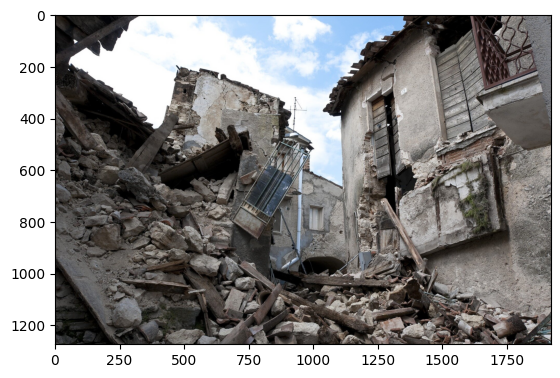

{'incident_probs': array([0.9986665], dtype=float32),
 'incidents': ['earthquake'],
 'place_probs': array([0.39004412], dtype=float32),
 'places': ['building outdoor']}


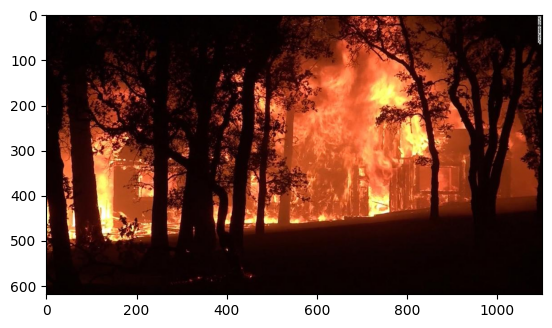

{'incident_probs': array([0.79706407], dtype=float32),
 'incidents': ['wildfire'],
 'place_probs': array([0.9731535], dtype=float32),
 'places': ['forest']}


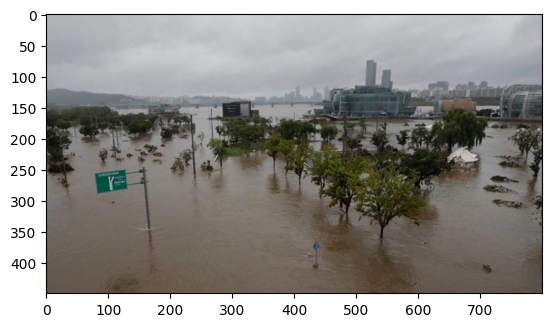

{'incident_probs': array([0.99754226], dtype=float32),
 'incidents': ['flooded'],
 'place_probs': array([0.5088126], dtype=float32),
 'places': ['building outdoor']}


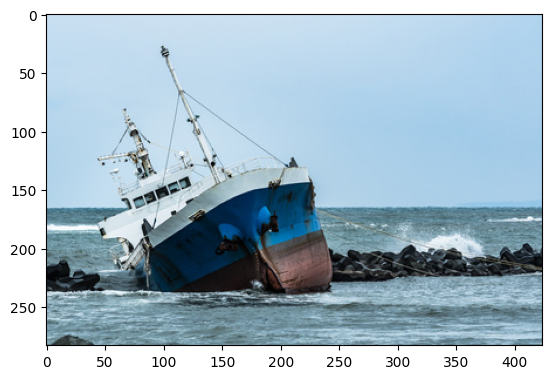

{'incident_probs': array([0.99999976], dtype=float32),
 'incidents': ['ship boat accident'],
 'place_probs': array([0.6524963], dtype=float32),
 'places': ['ocean']}


In [218]:
for image_filename in predictions:
    img = cv2.imread(image_filename)[:, :, ::-1].copy()
    plt.imshow(img)
    plt.show()
    pprint.pprint(predictions[image_filename])
